# Imports

In [47]:
import os
import time
from dotenv import load_dotenv
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from tqdm import tqdm
from spotipy import Spotify
import seaborn as sns
from matplotlib import pyplot as plt

# ETL

## Definiciones 

In [41]:
def get_playlist_info(playlist: dict, genre: str):
    '''Create dict merging playlist ID and genre'''
    return {
        "id": playlist["id"],
        "genre": genre 
    }


def get_track_info(track,genre):
    '''Create dict merging track info and genre'''
    return {
        "id": track["id"],
        "name": track["name"],
        "album_id": track["album"]["id"],
        "genre":genre
    }


def get_tracks_from_playlists(playlists: pd.DataFrame, sp: Spotify,verbose:bool=False,remove_nulls:bool=True):
    '''Create a DataFrame containing track info'''
    tracks_playlists = []
    errors = []

    for idx, playlist_id in enumerate(tqdm(playlists["id"])):
        try:
            playlist_tracks = sp.playlist_tracks(playlist_id=playlist_id)
            tracks_playlist = [get_track_info(item["track"],playlists["genre"][idx]) for item in playlist_tracks["items"]]
            tracks_playlists += tracks_playlist
        except TypeError as err:
            # print(f"Error en fila {idx}", err)
            errors.append(f"Error en fila {idx}, {err}")
            continue
    if verbose:
        print('Errors: ', errors)

    df_tracks = pd.DataFrame(tracks_playlists)

    # Validation of tracks with null values
    if verbose:
        print('Null in id col of tracks:', df_tracks["id"].isna().value_counts())

    # Delete rows with null values
    if remove_nulls:
        df_tracks.dropna(inplace=True)
    
    
    return df_tracks

def get_playlists_from_list(seeds:list,limit:int,verbose:bool=False,remove_nulls:bool=True):
    '''Generates a DataFrame, each row is one of <limit> playlists for each genre in seeds'''
    playlists = []
    for genre in seeds:
        # Search playlists by genre
        if verbose:
            print('➡️', end='')
        
        playlists_data = sp.search(q=genre, type='playlist', limit=limit, offset=0)
        playlists += [
            get_playlist_info(playlist, genre)
            for playlist in playlists_data['playlists']['items']
        ]
    df_playlists = pd.DataFrame(playlists)
    # Validation of playlists with null values
    if verbose:
        print(f'Null in id col of playlists', df_playlists["id"].isna().value_counts())
    # Delete rows with null values
    if remove_nulls:
        df_playlists.dropna(inplace=True)
    
    return df_playlists

def clear_duplicates(df_tracks:pd.DataFrame, remove:bool=False):
    '''Cleans duplicates from tracks, if remove is True, deleting them; if remove is False, combining their genres into a combined string like example:
        Example: id 4fgJe7zBjVXvs8HxtE21Y9 has 2 genres: 'anime' and 'j-pop'
        We will merge them into one: 'anime,j-pop'
    '''
    if remove:
        df_tracks_clean=df_tracks.drop_duplicates(subset=["id"])
    else:
        df_tracks_clean = df_tracks.groupby(["id", "name", "album_id"])["genre"].apply(lambda x: ','.join(x)).reset_index()
    return df_tracks_clean

def get_audio_features(df_tracks:pd.DataFrame,verbose:bool=False):
    '''From dataframe with track info, get a new dataFrame with audio features for each track'''
    audio_features = []

    for n in tqdm(range(len(df_tracks) // 100 + 1)):
        df_track_pack = df_tracks.iloc[n*100:(n+1)*100]
        audio_features_pack = sp.audio_features(tracks=list(df_track_pack['id']))
        audio_features += audio_features_pack
    #Delete none before converting into DataFrame    
    audio_features = [af for af in audio_features if af is not None]
    df_audio_features = pd.DataFrame(audio_features)

    if verbose:
        idx_af_bads = []
        for idx, af in enumerate(audio_features):
            if af is None:
                idx_af_bads.append(idx)
        print('Number of None values in audio features:', len(idx_af_bads))
    
    df_tracks_audio_features = pd.merge(
        df_tracks,
        df_audio_features,
        on="id",
        how="inner"
    )

    return df_tracks_audio_features

def es_multi_genero(song):
  return len(set(song['genre'].split(','))) >1 

def contar_multigeneros(songs:pd.DataFrame):
    multi_g = 0 
    for song in songs.genre:
        if es_multi_genero(song)>1:
            multi_g += 1
    print(multi_g, str(multi_g/songs.shape[0]*100)+'%')

## Generacion del Dataset

Cargamos las credenciales de la API de spotify

In [32]:
# Spotify API credentials
load_dotenv()
client_id = os.getenv('CLIENT_ID')
client_secret = os.getenv('CLIENT_SECRET')

# Spotify API authentication
client_credentials_manager = SpotifyClientCredentials(
    client_id='494d1b2d0fa940a58d9c4ce868a2bcb3',
    client_secret='fc927c45ed74477ab8ce4e2f1c490f62'
)
sp = spotipy.Spotify(
    client_credentials_manager=client_credentials_manager
)

Armamos la lista de generos de los cuales vamos a buscar canciones

In [6]:
#Genre seeds provided by Spotify
genres_seeds = [
    "acoustic", "afrobeat", "alt-rock", "alternative", "ambient", "anime", "black-metal", "bluegrass",
    "blues", "bossanova", "brazil", "breakbeat", "british", "cantopop", "chicago-house", "children", "chill",
    "classical", "club", "comedy", "country", "dance", "dancehall", "death-metal", "deep-house", "detroit-techno",
    "disco", "disney", "drum-and-bass", "dub", "dubstep", "edm", "electro", "electronic", "emo", "folk", "forro",
    "french", "funk", "garage", "german", "gospel", "goth", "grindcore", "groove", "grunge", "guitar", "happy",
    "hard-rock", "hardcore", "hardstyle", "heavy-metal", "hip-hop", "holidays", "honky-tonk", "house", "idm", "indian", 
    "indie", "indie-pop", "industrial", "iranian", "j-dance", "j-idol", "j-pop", "j-rock", "jazz", "k-pop", "kids",
    "latin", "latino", "malay", "mandopop", "metal", "metal-misc", "metalcore", "minimal-techno", "movies", "mpb",
    "new-age", "new-release", "opera", "pagode", "party", "philippines-opm", "piano", "pop", "pop-film", "post-dubstep",
    "power-pop", "progressive-house", "psych-rock", "punk", "punk-rock", "r-n-b", "rainy-day", "reggae", "reggaeton",
    "road-trip", "rock", "rock-n-roll", "rockabilly", "romance", "sad", "salsa", "samba", "sertanejo", "show-tunes",
    "singer-songwriter", "ska", "sleep", "songwriter", "soul", "soundtracks", "spanish", "study", "summer", "swedish",
    "synth-pop", "tango", "techno", "trance", "trip-hop", "turkish", "work-out", "world-music"
]

Generamos el dataset con los audio features que provee spotify

In [16]:
#Create dataframe with playlists id and genre
df_playlists = get_playlists_from_list(genres_seeds,10)

In [ ]:
# Save df_playlists to csv
df_playlists.to_csv('./datasets/playlists.csv', index=False)

In [22]:
tracks_playlists = get_tracks_from_playlists(playlists=df_playlists, sp=sp)

100%|██████████| 10/10 [00:04<00:00,  2.31it/s]

Errors:  []


In [26]:
tracks_playlists = clear_duplicates(tracks_playlists)

In [ ]:
# Save df_tracks to csv
tracks_playlists.to_csv('./datasets/tracks.csv', index=False)

In [28]:
df_tracks_audio_features = get_audio_features(tracks_playlists)

100%|██████████| 6/6 [00:02<00:00,  2.23it/s]


In [ ]:
# Save df_tracks_audio_features to csv
df_tracks_audio_features.to_csv('./datasets/tracks_audio_features.csv', index=False)

Al principio elegimos muchos generos y nos resulto dificil el analisis, por lo que volvimos para filtrarlos e ir de a poco

In [49]:
genres_selected = [
    "acoustic", "alt-rock", "alternative", "ambient", "blues", "bossanova", "chill", "classical", "country", 
    "disco", "edm", "folk", "forro", "funk", "gospel", "grunge", "heavy-metal", "hip-hop", "house","indie", 
    "jazz", "k-pop","latino", "metal", "opera", "pop", "punk","r-n-b","reggae", "reggaeton", "rock",
    "rockabilly", "salsa", "sertanejo", "ska", "soul", "tango", "techno"
]
tracks_selected = df_tracks_audio_features[df_tracks_audio_features['genre'].isin(genres_selected)]

Hasta aca el dataset puede llegar a contener canciones 'multi-genero' (por como manejamos los casos de IDs duplicados). Nosotros elegimos eliminarlos porque nos complejizan el analisis.

In [40]:
contar_multigeneros(tracks_selected)

0 0.0%


In [42]:
tracks_selected=tracks_selected.drop(tracks_selected[tracks_selected.apply(lambda x: es_multi_genero(x), axis=1)].index)

Por otro lado, tenemos canciones que, por pertenecer a dos o mas playlists del mismo genero, tienen el genero duplicado, vamos a limpiarlos

In [43]:
tracks_selected['genre'] = tracks_selected.genre.apply(lambda x: ''.join(set(x.split(','))) )

# EDA

In [33]:
tracks_selected.columns

Index(['id', 'name', 'album_id', 'genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [51]:
tracks_selected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                576 non-null    object 
 1   name              576 non-null    object 
 2   album_id          576 non-null    object 
 3   genre             576 non-null    object 
 4   danceability      576 non-null    float64
 5   energy            576 non-null    float64
 6   key               576 non-null    int64  
 7   loudness          576 non-null    float64
 8   mode              576 non-null    int64  
 9   speechiness       576 non-null    float64
 10  acousticness      576 non-null    float64
 11  instrumentalness  576 non-null    float64
 12  liveness          576 non-null    float64
 13  valence           576 non-null    float64
 14  tempo             576 non-null    float64
 15  type              576 non-null    object 
 16  uri               576 non-null    object 
 1

Key, Time Signature y Mode son categoricas segun la Documentacion de Spotify

In [52]:
tracks_selected['key']=tracks_selected.key.apply(lambda x: str(x))
tracks_selected['time_signature']=tracks_selected.time_signature.apply(str)
tracks_selected.drop(tracks_selected[tracks_selected['time_signature']=='0'].index,inplace=True) #son 3 rancias
tracks_selected['mode']=tracks_selected.time_signature.apply(str)

In [53]:
tracks_selected.describe()

,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000,576.000000
mean,0.569962,0.736233,-7.414554,0.060486,0.175363,0.053267,0.188505,0.603242,125.157561,235824.135417
std,0.135371,0.170382,2.959818,0.050674,0.232291,0.171340,0.152434,0.228230,27.348559,69854.485900
min,0.124000,0.111000,-21.985000,0.023500,0.000005,0.000000,0.022500,0.032700,73.762000,47132.000000
25%,0.477750,0.630750,-9.121500,0.033875,0.005638,0.000001,0.087500,0.445500,105.013750,191807.500000
50%,0.571500,0.759500,-7.013500,0.042550,0.053050,0.000084,0.131000,0.608000,123.771000,230573.500000
75%,0.662000,0.875250,-5.271250,0.063800,0.265500,0.004885,0.264000,0.789000,143.038250,271117.000000
max,0.933000,0.994000,0.706000,0.405000,0.921000,0.937000,0.946000,0.980000,205.973000,547107.000000


Vemos que duration, tempo y loudness estan en otras escalas, por lo que vamos a normalizarlas

In [55]:
#Normalize duration from milisec to sec
tracks_selected['duration_ms'] = tracks_selected['duration_ms']/60000  

#Normalizo la variable loudness
tracks_selected['loudness'] = tracks_selected['loudness']/60


#normalizo la variable tempo
tracks_selected['tempo'] = tracks_selected['tempo']/100

In [44]:
tracks_selected["genre"].value_counts()

genre
rock    576
Name: count, dtype: int64

Text(0, 0.5, 'Cantidad de géneros')

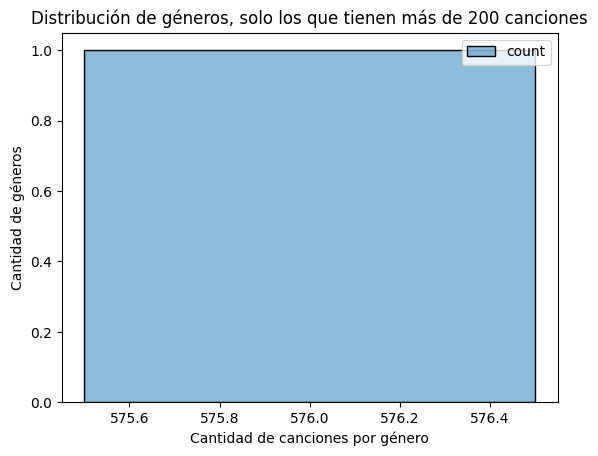

In [48]:
sns.histplot(tracks_selected.genre.value_counts().to_frame())
plt.title('Distribución de géneros, solo los que tienen más de 200 canciones')
plt.xlabel('Cantidad de canciones por género')
plt.ylabel('Cantidad de géneros')

In [ ]:
# save df as 'tracks_audio_features_selected.csv'
tracks_selected.to_csv('./datasets/tracks_audio_features_selected.csv', index=False)

Separamos los features numericos para hacer la matriz de correlacion general

Text(0.5, 1.0, 'Correlation matrix')

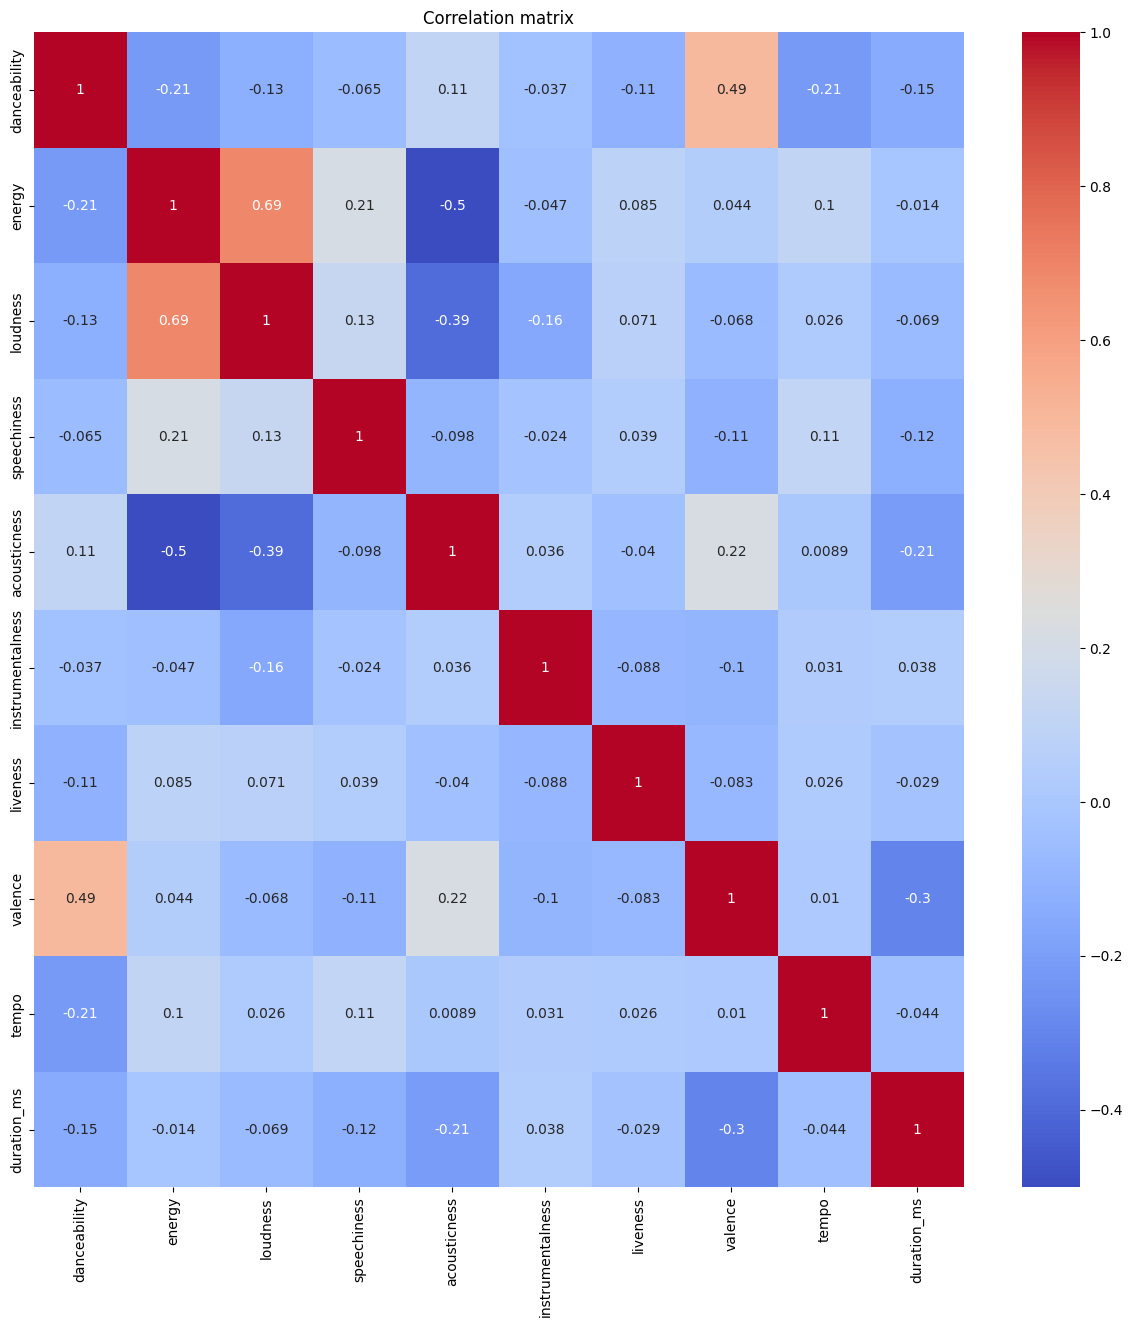

In [56]:
included_types = ['float64', 'int64']
selected_columns = tracks_selected.select_dtypes(include=included_types).columns
selected_variables = tracks_selected[selected_columns]

corr_matrix = selected_variables.corr()

plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation matrix')